In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
 
##Source: https://stackoverflow.com/a/14463362/8211103
import warnings
warnings.filterwarnings("ignore")
 
##Source : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
 
##Source : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
from sklearn.model_selection import RandomizedSearchCV
 
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn.metrics import roc_curve,auc
 
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score
 
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
 
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC
 
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
from sklearn.metrics import make_scorer
 
##Source : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.naive_bayes import GaussianNB
 
##Source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
 
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/X_TRAIN_FE_BERT.pkl','rb') as f:
  x_train, y_train = pickle.load(f)
 
print(x_train.shape,y_train.shape)
 
with open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/X_TEST_FE_BERT.pkl','rb') as f:
  x_test, y_test = pickle.load(f)
 
x_test.shape,y_test.shape

(1443899, 768) (1443899,)


((360975, 768), (360975,))

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/TEST_FE_BERT.pkl','rb') as f:
  test = pickle.load(f)
test.shape

(97320, 768)

In [ ]:
tempindex = np.arange(len(y_train) - sum(y_train))
random.shuffle(tempindex)
tempindex = tempindex[:sum(y_train)]
 
temp1 = x_train[y_train>0]
temp2 = x_train[y_train==0][tempindex]
 
x_tt = np.concatenate([temp1,temp2])
y_tt = pd.Series(len(temp1) * [1] + len(temp2) * [0])
 
del temp1
del temp2
 
tempindex = np.arange(len(x_tt))
random.shuffle(tempindex)
 
x_tt = x_tt[tempindex]
y_tt = y_tt[tempindex]
y_tt = y_tt.reset_index(drop=True)
 
x_tt.shape,y_tt.shape

((230934, 768), (230934,))

these x_tt and y_tt we will use for parameter tunning.

We have allready applied data cleaning, data preprocesing and Feature engineering using BERT model so lets apply basic ML models one by one.

In [ ]:
def plot_fpr_tpr(y_train,y_pred,ax1,name):
    fpr, tpr, threshold = roc_curve(y_train,y_pred)
    auc_score = round(auc(fpr,tpr),3)
    ax1.plot(fpr,tpr,label=f"{name} Auc-Score: {auc_score}")
    ax1.grid()
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.title.set_text('')
    print(f"{name} Auc-Score: {auc_score}")
    return threshold[np.argmax(tpr*(1-fpr))]
 
def plot(y_train,y_pred,y_test,y_test_pred):
  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
  threshold = plot_fpr_tpr(y_train,y_pred,ax1,'Train')
  _ = plot_fpr_tpr(y_test,y_test_pred,ax1,'Test')
  ax1.legend()
  
  y_pred = (y_pred>threshold).astype(int)
  y_test_pred = (y_test_pred>threshold).astype(int)
 
  cm = confusion_matrix(np.array(y_train),y_pred)
  sns.heatmap(cm,ax=ax2,fmt='6d',annot=True)
  ax2.title.set_text('Train Confution Metrics')
  ax2.set_ylabel('Actual label')
  ax2.set_xlabel('Predicted label')
 
  cm = confusion_matrix(np.array(y_test),y_test_pred)
  sns.heatmap(cm,ax=ax3,fmt='6d',annot=True)
  ax3.title.set_text('Test Confution Metrics')
  ax3.set_ylabel('Actual label')
  ax3.set_xlabel('Predicted label')
 
  ## We will use AUC's threshold for f1 score
  ## Here we will try to get high f1-score for our model
  f11 = round(f1_score(y_train,y_pred),3)
  f12 = round(f1_score(y_test,y_test_pred),3)
  print(f"Train F1-Score: {f11}, Test F1-Score: {f12},")
  return f11,f12
 
def f1_with_auc(y_train,y_pred):
  fpr, tpr, threshold = roc_curve(y_train,y_pred)
  threshold = threshold[np.argmax(tpr*(1-fpr))]
  y_train = (y_train>threshold).astype(int)
  y_pred = (y_pred>threshold).astype(int)
  return f1_score(y_train,y_pred)
 
 
scorrer = make_scorer(f1_with_auc,greater_is_better=True,needs_proba=True)

##1. Logistic Regression

In [ ]:
class_weight = {
    0:(len(y_train) - sum(y_train))/len(y_train),
    1:sum(y_train)/len(y_train)    
}
class_weight

{0: 0.9200311102092321, 1: 0.07996888979076791}

In [ ]:
lr = LogisticRegression(max_iter=1000)
params={
    'C' : [0.0001,0.001,0.01,0.1,1,10,100,1000]
}
rs = RandomizedSearchCV(lr, params, random_state=4444,return_train_score=True,verbose=10,cv=3,scoring=scorrer,n_jobs=-1)
rs.fit(x_tt,y_tt)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 23.7min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 28.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=1000,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=4444, refit=True,
                   return_train_score=True,
                   scorin

In [ ]:
rs.best_params_

{'C': 1000}

Train Auc-Score: 0.855
Test Auc-Score: 0.856
Train F1-Score: 0.349, Test F1-Score: 0.349,


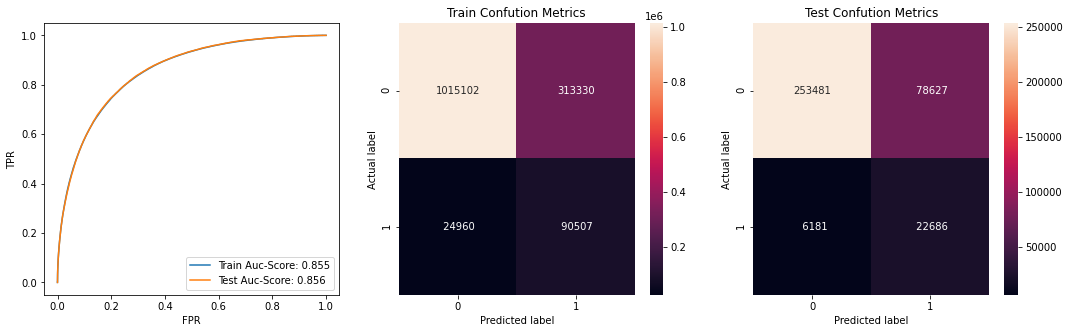

In [ ]:
lr = LogisticRegression(class_weight=class_weight,max_iter=1000,C=1000)
lr.fit(x_train,y_train)
y_pred = lr.predict_proba(x_train)[:,1];
y_test_pred = lr.predict_proba(x_test)[:,1]
train_f1,test_f1 = plot(y_train,y_pred,y_test,y_test_pred)
pickle.dump(lr,open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/lr.pkl','wb'))

In [ ]:
del lr
del rs
del y_pred
del y_test_pred
observations = pd.DataFrame({'Algorithm':['Logistic-Regression'],'Hyperparameter':['C:1000'],"Train F1-Score":[train_f1],"Validation F1-Score":[test_f1]})
display(observations)
del train_f1
del test_f1

,Algorithm,Hyperparameter,Train F1-Score,Validation F1-Score
0,Logistic-Regression,C:1000,0.349,0.349


Kaggle Submission:
* Score: 0.80723
* Rank: 2427 in TOP 77.88%

![](https://drive.google.com/uc?export=view&id=1lZV6f8KPZsqAjeIpzCfUqMPt7qevcBH_)

##2. Naive Bayes

Train Auc-Score: 0.618
Test Auc-Score: 0.62
Train F1-Score: 0.191, Test F1-Score: 0.192,


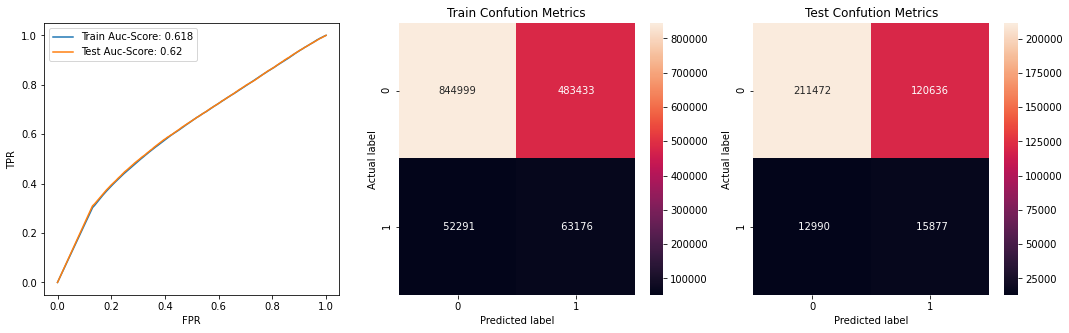

In [ ]:
gnb = GaussianNB()
gnb.fit(x_tt,y_tt)
y_pred = gnb.predict_proba(x_train)[:,1];
y_test_pred = gnb.predict_proba(x_test)[:,1]
train_f1,test_f1 = plot(y_train,y_pred,y_test,y_test_pred)
pickle.dump(gnb,open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/gnb.pkl','wb'))

In [ ]:
del gnb
del y_pred
del y_test_pred
observations = pd.concat([observations,pd.DataFrame({'Algorithm':['Naive Bayes'],'Hyperparameter':['NA'],"Train F1-Score":[train_f1],"Validation F1-Score":[test_f1]})])
display(observations)
del train_f1
del test_f1

,Algorithm,Hyperparameter,Train F1-Score,Validation F1-Score
0,Logistic-Regression,C:1000,0.349,0.349
0,Naive Bayes,NA,0.192,0.192


Kaggle Submission:
* Score: 0.60164
* Rank: 2496 in TOP 80.10%

![](https://drive.google.com/uc?export=view&id=1CC3rcTVZ4peA_wUYsfYn_BWe6dTmxvOB)

## 3. Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
params={
    'max_depth':[5,10,15,20,25,30],
    'min_samples_split':[2,4,6,8,10,12],
    'min_samples_leaf':[2,4,6,8,10,12],
    'max_leaf_nodes':[2,4,6,8,10,12]
}
rs = RandomizedSearchCV(dt, params, random_state=4444,return_train_score=True,verbose=10,cv=7,scoring=scorrer,n_jobs=-1)
rs.fit(x_tt,y_tt)
rs.best_params_

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 45.1min finished


{'max_depth': 10,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 6,
 'min_samples_split': 12}

Train Auc-Score: 0.641
Test Auc-Score: 0.639
Train F1-Score: 0.205, Test F1-Score: 0.204,


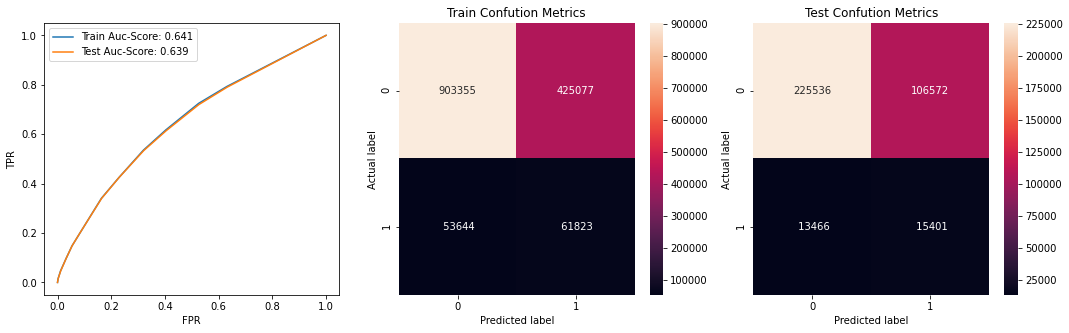

In [ ]:
dt = DecisionTreeClassifier(class_weight=class_weight,max_depth=10,max_leaf_nodes=12,min_samples_leaf=6,min_samples_split=12)
dt.fit(x_train,y_train)
y_pred = dt.predict_proba(x_train)[:,1];
y_test_pred = dt.predict_proba(x_test)[:,1]
train_f1,test_f1 = plot(y_train,y_pred,y_test,y_test_pred)
pickle.dump(dt,open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/dt.pkl','wb'))

In [ ]:
del dt
del y_pred
del y_test_pred
del rs
observations = pd.concat([observations,pd.DataFrame({'Algorithm':['Decision Tree'],'Hyperparameter':["{'max_depth': 10,'max_leaf_nodes': 12,'min_samples_leaf': 6,'min_samples_split': 12}"],"Train F1-Score":[train_f1],"Validation F1-Score":[test_f1]})])
display(observations)
del train_f1
del test_f1

,Algorithm,Hyperparameter,Train F1-Score,Validation F1-Score
0,Logistic-Regression,C:1000,0.349,0.349
0,Naive Bayes,NA,0.192,0.192
0,Decision Tree,"{'max_depth': 10,'max_leaf_nodes': 12,'min_sam...",0.205,0.204


Kaggle Submission:
* Score: 0.61751
* Rank: 2492 in TOP 79.97%

![](https://drive.google.com/uc?export=view&id=181CJkZ1ReZGl11ZzRNDHAQMqURnJPEqF)

##4. Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
params={
    'n_estimators':[200,500,1000,2000,3000],
    'max_depth':[5,10,15,20,25,30],
    'min_samples_split':[2,4,6,8,10,12],
    'min_samples_leaf':[2,4,6,8,10,12],
    'max_leaf_nodes':[2,4,6,8,10,12]
}
rs = RandomizedSearchCV(rf, params, random_state=4444,return_train_score=True,verbose=10,cv=3,scoring=scorrer,n_jobs=-1)
rs.fit(x_tt,y_tt)
rs.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 98.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 151.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 287.6min remaining: 32.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 301.4min finished


{'max_depth': 20,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 200}

Train Auc-Score: 0.755
Test Auc-Score: 0.753
Train F1-Score: 0.264, Test F1-Score: 0.263,


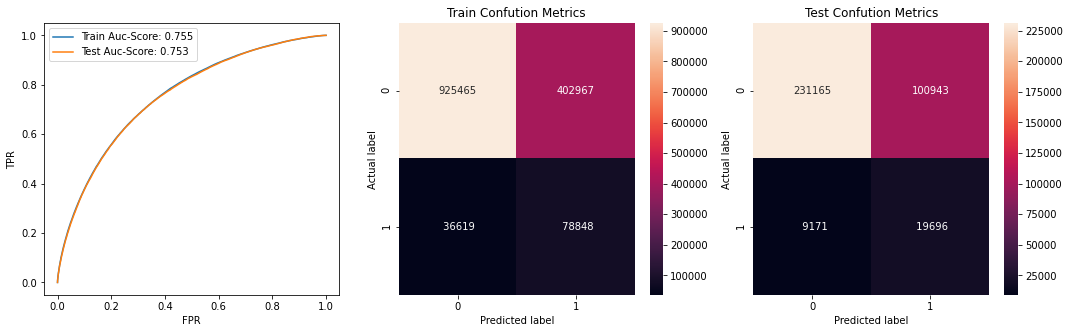

In [ ]:
rf = RandomForestClassifier(n_jobs=-1,max_depth=20,max_leaf_nodes=12,min_samples_leaf=10,min_samples_split=8,n_estimators=200,class_weight=class_weight)
rf.fit(x_train,y_train)
y_pred = rf.predict_proba(x_train)[:,1];
y_test_pred = rf.predict_proba(x_test)[:,1]
train_f1,test_f1 = plot(y_train,y_pred,y_test,y_test_pred)
pickle.dump(rf,open('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/rf.pkl','wb'))

In [ ]:
del rf
del y_pred
del y_test_pred
del rs
observations = pd.concat([observations,pd.DataFrame({'Algorithm':['Random Forest'],'Hyperparameter':["{'max_depth': 20,'max_leaf_nodes': 12,'min_samples_leaf': 10,'min_samples_split': 8,'n_estimators:200'}"],"Train F1-Score":[train_f1],"Validation F1-Score":[test_f1]})])
display(observations)
del train_f1
del test_f1

,Algorithm,Hyperparameter,Train F1-Score,Validation F1-Score
0,Logistic-Regression,C:1000,0.349,0.349
0,Naive Bayes,NA,0.192,0.192
0,Decision Tree,"{'max_depth': 10,'max_leaf_nodes': 12,'min_sam...",0.205,0.204
0,Random Forest,"{'max_depth': 20,'max_leaf_nodes': 12,'min_sam...",0.264,0.263


Kaggle Submission:
* Score: 0.71493
* Rank: 2463 in TOP 76.58%

![](https://drive.google.com/uc?export=view&id=1R0nkvrAQOe4zNWEGtFVR3k40Ej3RCvEp)

##5. Gradient Boosting

In [ ]:
xgb = XGBClassifier(tree_method='gpu_hist')
params={
    "learning_rate":[0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
    'max_depth':[3,4,5,6,8,10,12,15],
    'min_child_weight':[1,3,5,7],
    'gamma':[0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree':[0.3,0.4,0.5,0.7],
    'n_estimators':[200,500,1000,2000,3000]
}
rs = RandomizedSearchCV(xgb, params, random_state=4444,return_train_score=True,verbose=10,cv=7,scoring=scorrer,n_jobs=-1)
rs.fit(x_tt,y_tt)
rs.best_params_

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 36.5min finished


{'colsample_bytree': 0.5,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 7,
 'n_estimators': 3000}

Train Auc-Score: 0.946
Test Auc-Score: 0.853
Train F1-Score: 0.514, Test F1-Score: 0.388,


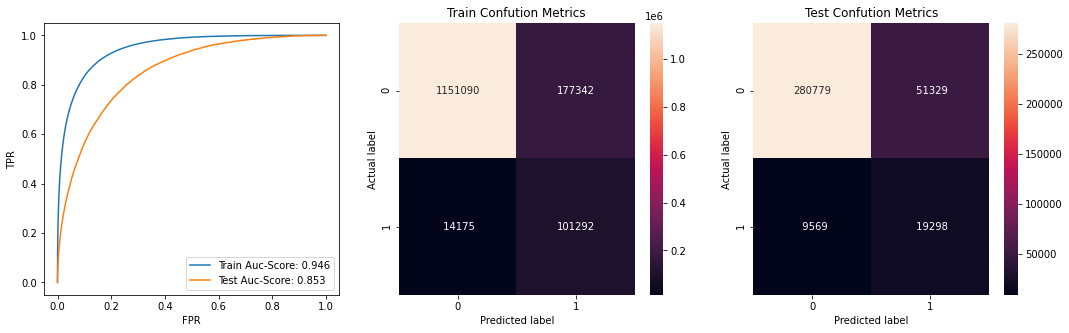

In [ ]:
xgb = XGBClassifier(tree_method='gpu_hist',n_estimators=3000,min_child_weight=7,max_depth=5,learning_rate=0.1,gamma=0.2,colsample_bytree=0.5)
xgb.fit(x_train,y_train)
y_pred = xgb.predict_proba(x_train)[:,1];
y_test_pred = xgb.predict_proba(x_test)[:,1]
train_f1,test_f1 = plot(y_train,y_pred,y_test,y_test_pred)
xgb.save_model('/content/drive/MyDrive/Colab Notebooks/AAIC/Case Study 1/Models/xgb.json')

In [ ]:
del xgb
del y_pred
del y_test_pred
del rs
observations = pd.concat([observations,pd.DataFrame({'Algorithm':['Xgboosting'],'Hyperparameter':["{'colsample_bytree': 0.5,'gamma': 0.2,'learning_rate': 0.1,'max_depth': 5,'min_child_weight': 7,'n_estimators': 3000}"],"Train F1-Score":[train_f1],"Validation F1-Score":[test_f1]})])
display(observations)
del train_f1
del test_f1

,Algorithm,Hyperparameter,Train F1-Score,Validation F1-Score
0,Logistic-Regression,C:1000,0.349,0.349
0,Naive Bayes,NA,0.192,0.192
0,Decision Tree,"{'max_depth': 10,'max_leaf_nodes': 12,'min_sam...",0.205,0.204
0,Random Forest,"{'max_depth': 20,'max_leaf_nodes': 12,'min_sam...",0.264,0.263
0,Xgboosting,"{'colsample_bytree': 0.5,'gamma': 0.2,'learnin...",0.514,0.388


Kaggle Submission:
* Score: 0.80287
* Rank: 2429 in TOP 77.95%

![](https://drive.google.com/uc?export=view&id=12vKcjalaxeQwPw-HLnE6hyp6HbEnP7NG)